In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error


In [2]:
#load dataset
df = pd.read_csv("Data.csv",parse_dates=["date_time"])
df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN


In [3]:
# Display basic info
print(df.info())  # Check data types and missing values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17140913 entries, 0 to 17140912
Data columns (total 8 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date_time     datetime64[ns]
 1   v_red         float64       
 2   current       float64       
 3   power_factor  float64       
 4   kwh           float64       
 5   Source        object        
 6   v_blue        float64       
 7   v_yellow      float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.0+ GB
None


In [4]:
print(df.describe())  # Summary statistics

                           date_time         v_red       current  \
count                       17140913  5.799428e+06  1.714091e+07   
mean   2024-03-20 23:11:12.652286720  2.197882e+01  2.501388e-01   
min              2023-06-24 23:45:00  0.000000e+00  0.000000e+00   
25%              2023-12-20 14:35:00  0.000000e+00  0.000000e+00   
50%              2024-03-25 13:45:00  0.000000e+00  0.000000e+00   
75%              2024-06-30 04:35:00  0.000000e+00  0.000000e+00   
max              2024-09-23 23:55:00  2.400000e+02  4.539000e+01   
std                              NaN  5.782394e+01  1.964621e+00   

       power_factor           kwh        v_blue      v_yellow  
count  1.714091e+07  1.714091e+07  5.746850e+06  5.594635e+06  
mean   6.709645e-02  2.491696e-03  1.851702e+01  1.834869e+01  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
75%

In [5]:
#check missing values
df.isnull().sum()

date_time              0
v_red           11341485
current                0
power_factor           0
kwh                    0
Source                 0
v_blue          11394063
v_yellow        11546278
dtype: int64

In [6]:
# Count missing values per row
df["missing_voltages"] = df[["v_red", "v_blue", "v_yellow"]].isnull().sum(axis=1)

In [7]:
# Check if users with missing v_blue and v_yellow have only single-phase
single_phase_users = df[df["missing_voltages"] == 2]  # Missing v_blue and v_yellow

In [8]:
print("Number of single-phase users identified:", single_phase_users["Source"].nunique())

Number of single-phase users identified: 251


In [9]:
print(single_phase_users.head())

            date_time   v_red  current  power_factor       kwh  \
0 2024-07-22 18:20:00  137.65     0.08          0.72  0.000661   
1 2024-07-22 18:25:00  122.82     0.08          0.73  0.000598   
2 2024-07-22 18:30:00  119.70     0.08          0.74  0.000591   
3 2024-07-22 18:35:00  124.53     0.08          0.75  0.000623   
4 2024-07-22 18:40:00  134.84     0.08          0.74  0.000665   

                           Source  v_blue  v_yellow  missing_voltages  
0  consumer_device_10_data_user_1     NaN       NaN                 2  
1  consumer_device_10_data_user_1     NaN       NaN                 2  
2  consumer_device_10_data_user_1     NaN       NaN                 2  
3  consumer_device_10_data_user_1     NaN       NaN                 2  
4  consumer_device_10_data_user_1     NaN       NaN                 2  


In [10]:
#Handling Missing Values
# Identify single-phase users (users missing both v_blue and v_yellow)
single_phase_users = df[df["missing_voltages"] == 2]["Source"].unique()

In [11]:
# Fill v_blue and v_yellow with 0 for single-phase users
df.loc[df["Source"].isin(single_phase_users), ["v_blue", "v_yellow"]] = 0

In [12]:
# Forward-fill missing values for three-phase users
df["v_red"].fillna(method="ffill", inplace=True)
df["v_blue"].fillna(method="ffill", inplace=True)
df["v_yellow"].fillna(method="ffill", inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_10380\944574377.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["v_red"].fillna(method="ffill", inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_10380\944574377.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["v_blue"].fillna(method="ffill", inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_10380\944574377.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["v_yellow"].fillna(method="ffill", inplace=True)


In [13]:
# Interpolate remaining missing values for three-phase users
df["v_red"].interpolate(method="linear", inplace=True)
df["v_blue"].interpolate(method="linear", inplace=True)
df["v_yellow"].interpolate(method="linear", inplace=True)

In [14]:
# Final median imputation for any remaining missing values (for robustness)
df["v_red"].fillna(df["v_red"].median(), inplace=True)
df["v_blue"].fillna(df["v_blue"].median(), inplace=True)
df["v_yellow"].fillna(df["v_yellow"].median(), inplace=True)

#  Exploratory Data Analysis (EDA)

## Plot Energy Load Generation Over Time

In [15]:
# Check unique values in categorical columns (if any)
print(df["Source"].unique())  # Checking different sources of power consumption

['consumer_device_10_data_user_1' 'consumer_device_10_data_user_10'
 'consumer_device_10_data_user_11' 'consumer_device_10_data_user_12'
 'consumer_device_10_data_user_13' 'consumer_device_10_data_user_14'
 'consumer_device_10_data_user_15' 'consumer_device_10_data_user_16'
 'consumer_device_10_data_user_17' 'consumer_device_10_data_user_18'
 'consumer_device_10_data_user_2' 'consumer_device_10_data_user_3'
 'consumer_device_10_data_user_4' 'consumer_device_10_data_user_5'
 'consumer_device_10_data_user_6' 'consumer_device_10_data_user_7'
 'consumer_device_10_data_user_8' 'consumer_device_10_data_user_9'
 'consumer_device_11_data_user_1' 'consumer_device_11_data_user_10'
 'consumer_device_11_data_user_11' 'consumer_device_11_data_user_12'
 'consumer_device_11_data_user_13' 'consumer_device_11_data_user_14'
 'consumer_device_11_data_user_15' 'consumer_device_11_data_user_16'
 'consumer_device_11_data_user_17' 'consumer_device_11_data_user_18'
 'consumer_device_11_data_user_2' 'consumer_

Checking for Outliers
To detect unusual voltage, current, and kWh values, we can use boxplots:

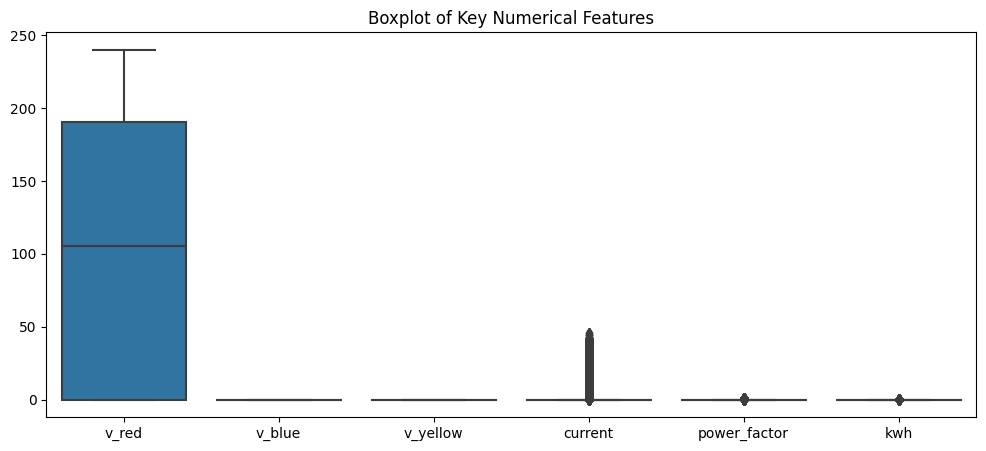

In [16]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[["v_red", "v_blue", "v_yellow", "current", "power_factor", "kwh"]])
plt.title("Boxplot of Key Numerical Features")
plt.show()


Visualizing Energy Consumption Trends

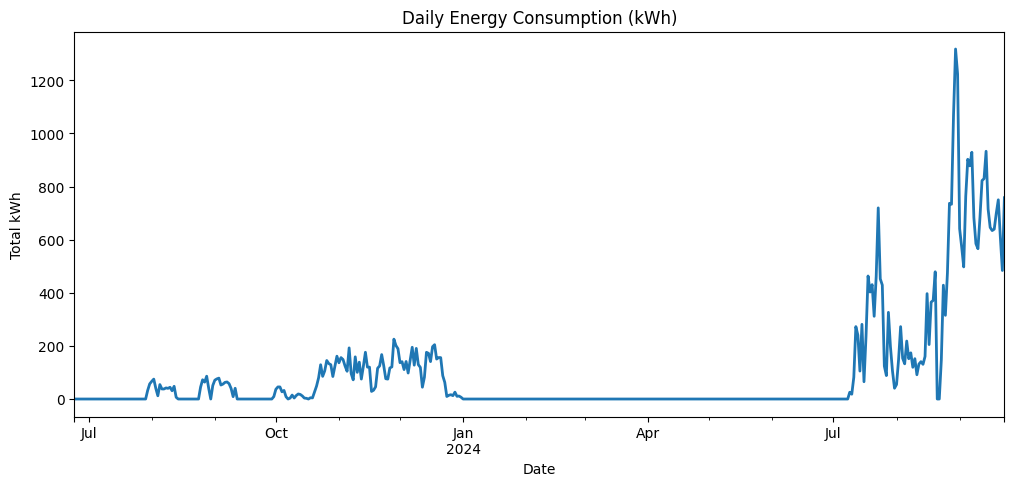

In [17]:
df["te_time"] = pd.to_datetime(df["date_time"])  # Ensure te_time is in datetime format
df.set_index("te_time", inplace=True)

# Plot total energy consumption per day
df.resample("D")["kwh"].sum().plot(figsize=(12, 5), title="Daily Energy Consumption (kWh)", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Total kWh")
plt.show()
